<a href="https://colab.research.google.com/github/barbaroja2000/imagery/blob/main/leonardo_ai.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import requests
import json

In [ ]:
#@title Load Keys
#@markdown Utitily to load keys from fs, replace with environ vars if not using
!python -m pip install python-dotenv
import os

from google.colab import drive
drive.mount('/content/drive/', force_remount=True)
import dotenv
dotenv.load_dotenv('/content/drive/MyDrive/keys/keys.env')

Mounted at /content/drive/


True

In [ ]:
LEONARDO_AI_API_KEY = os.environ.get("LEONARDO_AI_API_KEY")

In [66]:
NEGATIVE_PROMPT="""
((nude) ,(NSFW),deformed, bad anatomy, disfigured, poorly drawn face, mutation, mutated, extra limb, ugly,
disgusting, poorly drawn hands, missing limb, floating limbs, disconnected limbs, malformed hands, blurry,
((((mutated hands and fingers)))), watermark, watermarked, distorted hands, amputation, missing hands, obese,
 doubled face, double hands, cropped, out of frame, worst quality, low quality, jpeg artifacts, poorly lit, glitch, error,
  out of focus, missing arms, missing legs, extra arms, extra legs, fused fingers, too many fingers
"""

In [227]:
import requests
import json
import time
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
import urllib.request
import numpy as np

class LeonardoAI:
    def __init__(self, api_key, num_inference_steps=30, guidance_scale=7, negative_prompt=NEGATIVE_PROMPT, preset_style="LEONARDO"):

        if not 30 <= num_inference_steps <= 60:
              raise ValueError("num_inference_steps must be between 30 and 60")
        self.num_inference_steps = num_inference_steps

        if not 1 <= guidance_scale <= 20:
              raise ValueError("guidance_scale must be between 1 and 20")
        self.guidance_scale = guidance_scale

        self.base_url = "https://cloud.leonardo.ai/api/rest/v1/generations"
        self.api_key = api_key
        self.negative_prompt=negative_prompt
        self.preset_style=preset_style

    def retrieve_images(self, generation_id):
        url = f"{self.base_url}/{generation_id}"
        headers = {
            "accept": "application/json",
            "authorization": f"Bearer {self.api_key}"
        }

        while True:  # Keep checking until the images are ready
            response = requests.get(url, headers=headers)
            data = json.loads(response.text)

            # Check if the generated_images field is not empty
            generations = data.get("generations_by_pk", {}).get("generated_images", [])
            status = data.get("generations_by_pk", {}).get("status", "")

            if generations or status != "PENDING":
                break

            time.sleep(10)  # Wait for 10 seconds before checking again

        return generations

    def generate_image(self, prompts, model_id="6bef9f1b-29cb-40c7-b9df-32b51c1f67d3", width=512, height=512, num_images=1):
        if isinstance(prompts, str):
            prompts = [prompts]  # Convert single prompt to a list

        """
                payload = {
                    "prompt": "An oil painting of a cat",
                    "modelId": "...",
                    "width": 512,
                    "height": 512,
                    "negative_prompt": "...",
                    "init_generation_image_id": "...",
                    "init_image_id": "...",
                    "init_strength": "0.",
                    "presetStyle": "LEONARDO",
                    "guidance_scale": "0.",
                    "num_inference_steps": 0,
                    "promptMagic": True
                }
        """

        # Store generation IDs for all prompts
        generation_ids = []
        for indx, prompt in enumerate(prompts):
            payload = {
                "prompt": prompt,
                "negative_prompt": self.negative_prompt,
                "modelId": model_id,
                "width": width,
                "height": height,
                "num_images": num_images if len(prompts) == 1 else 1,  # Use num_images if single prompt, else 1
                "num_inference_steps": self.num_inference_steps,
                "guidance_scale": self.guidance_scale,
            }
            headers = {
                "accept": "application/json",
                "content-type": "application/json",
                "authorization": f"Bearer {self.api_key}"
            }
            if (indx+ 1) % 2 == 0:  # Check if the current iteration is a multiple of 3
              print(f"Iteration {indx}: Waiting for 5 seconds...")
              time.sleep(10)  # Wait for 10 seconds

            response = requests.post(self.base_url, json=payload, headers=headers)
            print(response.text)
            generation_id = json.loads(response.text)["sdGenerationJob"]["generationId"]
            generation_ids.append(generation_id)

        # Retrieve all images
        all_generations = []
        for generation_id in generation_ids:
            generations = self.retrieve_images(generation_id)
            all_generations.extend(generations)

        # Display images
        self.display_images(all_generations)

    def display_images(self, generations):
        num_images = len(generations)
        if num_images == 0:
            return

        if num_images <= 3:
            num_rows = 1
            num_cols = num_images
        else:
            num_rows = int(num_images**0.5)
            while num_rows * num_rows < num_images:
                num_rows += 1
            num_cols = num_images // num_rows + (1 if num_images % num_rows > 0 else 0)

        total_slots = num_rows * num_cols

        fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols * 3, num_rows * 3))
        axes = axes.flatten() if total_slots > 1 else [axes]

        # Iterate through all the slots in the grid
        for idx in range(total_slots):
            ax = axes[idx]
            ax.axis("off")

            # Create a blank image
            blank_image = np.ones((512, 512, 3), dtype=np.uint8) * 255

            # Display a real image if available, otherwise display a blank image
            if idx < num_images:
                try:
                    with urllib.request.urlopen(generations[idx]["url"]) as url:
                        image = Image.open(url)
                        image_array = np.array(image)
                        ax.imshow(image_array)
                except Exception as e:
                    print(f"Error retrieving image {idx}: {e}")
                    ax.imshow(blank_image)
            else:
                ax.imshow(blank_image)

        plt.tight_layout()
        plt.show()

In [173]:
prompt="Comic book cover: {A vivid scene at the old Wishing Well. close up on face of  old Leprachaun. The background is filled with lush Irish landscapes and a sparkling rainbow.}"

In [184]:
leonardo = LeonardoAI(api_key=LEONARDO_AI_API_KEY, num_inference_steps=60,negative_prompt=None, guidance_scale=15)

{"sdGenerationJob":{"generationId":"8a6737f5-0d16-4da3-bada-636c4dbfb532"}}


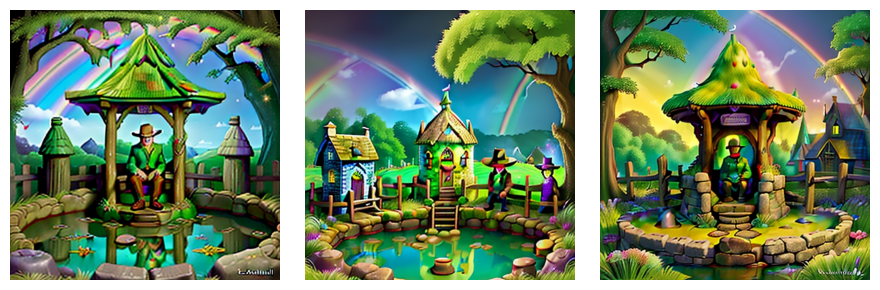

In [231]:
#@title 3D animation style
generation_id = leonardo.generate_image(prompts=prompt, width=512, height=512, num_images=3, model_id="d69c8273-6b17-4a30-a13e-d6637ae1c644")
generations = leonardo.retrieve_images(generation_id)
leonardo.display_images(generations)

{"sdGenerationJob":{"generationId":"a20a9567-2f8e-4945-8449-d125b0977a3a"}}


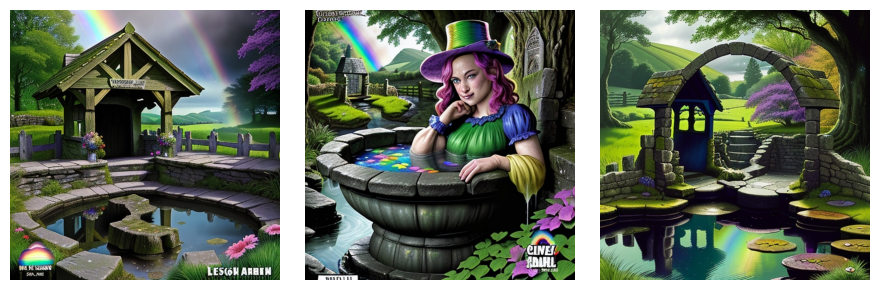

In [230]:
#@title Dreamshaper v7
generation_id = leonardo.generate_image(prompts=prompt, width=512, height=512, num_images=3, model_id="ac614f96-1082-45bf-be9d-757f2d31c174")
generations = leonardo.retrieve_images(generation_id)
leonardo.display_images(generations)

{"sdGenerationJob":{"generationId":"12266550-d3fb-421d-ad6e-2bd7e5e98e7e"}}


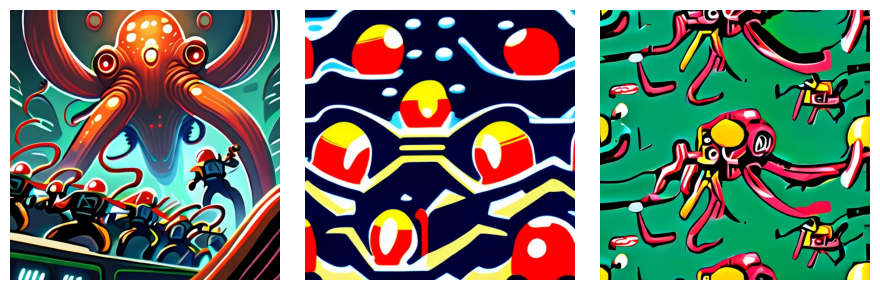

In [229]:
#@title SDXL0.9
custom_prompt="A chaotic battle between a brave squadron of human defenders and a relentless swarm of mutated space invaders, their tentacles writhing in the air."
generation_id = leonardo.generate_image(prompts=custom_prompt, width=512, height=512, num_images=3, model_id="b63f7119-31dc-4540-969b-2a9df997e173")
generations = leonardo.retrieve_images(generation_id)
leonardo.display_images(generations)

{"sdGenerationJob":{"generationId":"e3ee667c-82dd-49d5-93db-786ec7bc119e"}}


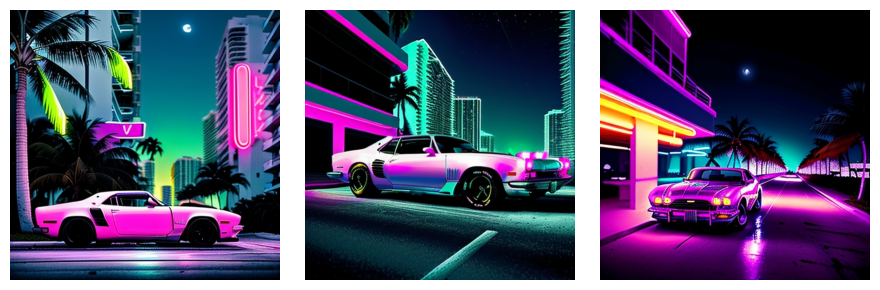

In [228]:
#@title Absolute Reality v1.6
leonardo = LeonardoAI(api_key=LEONARDO_AI_API_KEY, num_inference_steps=60,negative_prompt=None, guidance_scale=20)
custom_prompt="A neon-lit Miami nightscape, with a sleek, classic car cruising down the street, its chrome glinting in the moonlight."
generation_id = leonardo.generate_image(prompts=custom_prompt, width=512, height=512, num_images=3, model_id="e316348f-7773-490e-adcd-46757c738eb7")
generations = leonardo.retrieve_images(generation_id)
leonardo.display_images(generations)


In [224]:
prompts=[
    "A vibrant reggae dance party with  colorful dancers swaying to the beat of the music.",
    "A chaotic swarm of mutated space invaders, their metallic bodies reflecting the light of a distant nebula.",
    "A neon-lit Miami nightscape, with a sleek, classic car cruising down the street, its chrome glinting in the moonlight.",
    "Grinning Leprachaun smoking a pipe",
    "A woolly mammoth trudges through a frozen tundra, its breath visible in the frigid air.",
    "Ancient rome caeser grandstanding",
    "A kaleidoscope of colors reflecting off a spinning disco ball, set against a backdrop of twinkling stars.",
    "A mysterious tiki island shrouded in fog, with ancient totems standing guard over the secrets of the island.",
    "A vibrant, technicolor landscape of candy-coated bubbles, shimmering in the sunlight.",
    "A titanic clash between two prehistoric beasts, their powerful roars echoing through the ancient landscape.",
    "race between two tramps, each trying to out-maneuver the other in a surreal, dream-like landscape."]

{"sdGenerationJob":{"generationId":"4aefccd2-b8ad-400e-bca9-f243b54efc75"}}
Iteration 1: Waiting for 5 seconds...
{"sdGenerationJob":{"generationId":"dd9b6c4f-70ae-4978-81f7-6781ce7859fc"}}
{"sdGenerationJob":{"generationId":"91d14d4c-f69d-44de-9490-314d79e80146"}}
Iteration 3: Waiting for 5 seconds...
{"sdGenerationJob":{"generationId":"2002e4c3-2592-4524-bdbb-f5d7232063d7"}}
{"sdGenerationJob":{"generationId":"aee0b50a-126d-4c14-898b-858f7f8c504a"}}
Iteration 5: Waiting for 5 seconds...
{"sdGenerationJob":{"generationId":"df66cfc3-beb3-43ba-8eaa-167ab7639b08"}}
{"sdGenerationJob":{"generationId":"13b75ab2-f7e1-430e-8fe7-4f4d1bb8a368"}}
Iteration 7: Waiting for 5 seconds...
{"sdGenerationJob":{"generationId":"0761635f-3cf0-4022-ac72-371cf3f4d962"}}
{"sdGenerationJob":{"generationId":"216429b8-da59-4885-a699-10831d0f0476"}}
Iteration 9: Waiting for 5 seconds...
{"sdGenerationJob":{"generationId":"3afb82dd-6cec-44b4-bb2a-d30ae7b32ad4"}}
{"sdGenerationJob":{"generationId":"eef4733b-b91c-

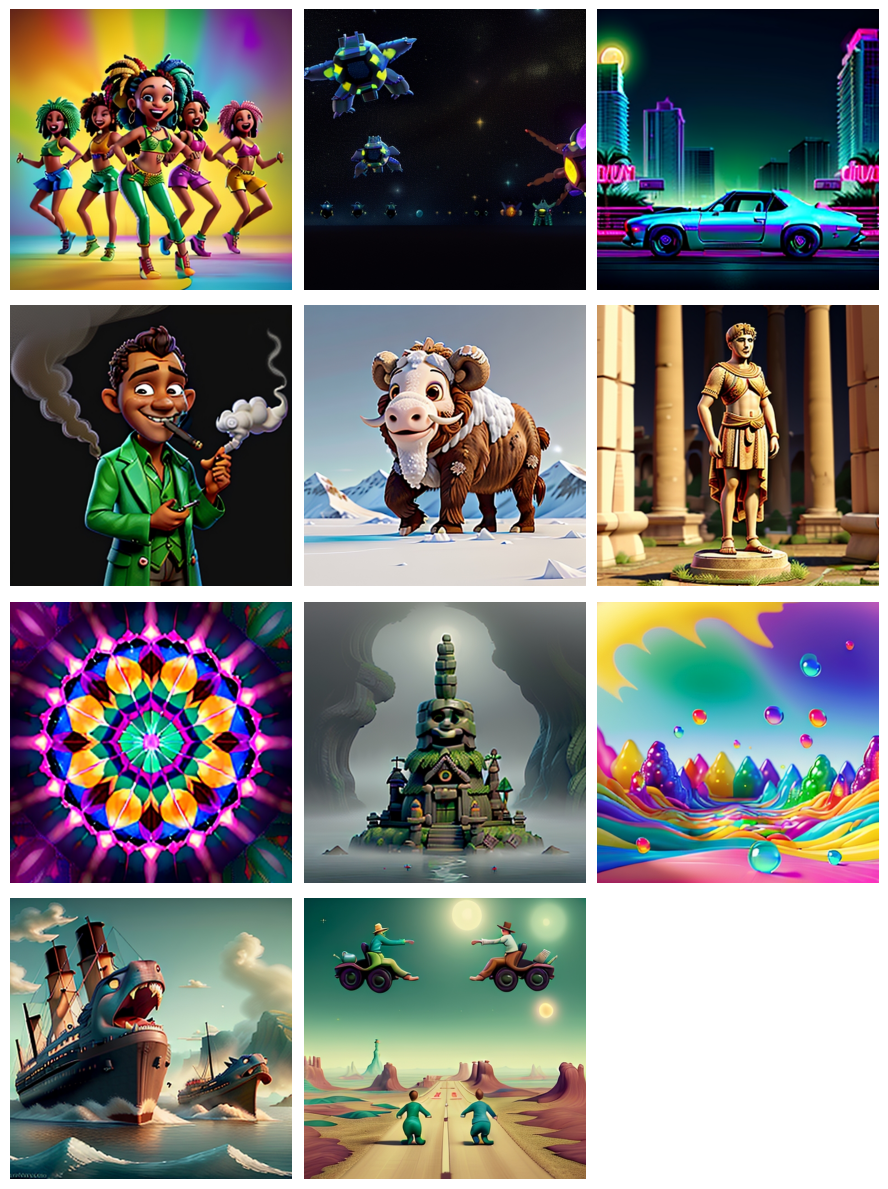

In [225]:
#@title Grid from multiple prompts
leonardo = LeonardoAI(api_key=LEONARDO_AI_API_KEY, num_inference_steps=60,negative_prompt=None, guidance_scale=15)
generation_id = leonardo.generate_image(prompts=prompts, width=512, height=512, num_images=3, model_id="d69c8273-6b17-4a30-a13e-d6637ae1c644")
generations = leonardo.retrieve_images(generation_id)
leonardo.display_images(generations)

{"sdGenerationJob":{"generationId":"ede1864b-23b8-4f9e-a89e-e5e37f0ebad9"}}
Iteration 1: Waiting for 5 seconds...
{"sdGenerationJob":{"generationId":"a05b85c0-be70-4a66-a977-4cee532718e7"}}
{"sdGenerationJob":{"generationId":"51db7644-0715-4cda-9592-de332c35d772"}}
Iteration 3: Waiting for 5 seconds...
{"sdGenerationJob":{"generationId":"9007f741-8c1f-432f-b7cf-f337a7dc3691"}}
{"sdGenerationJob":{"generationId":"e6b7d089-79ab-4ce2-9e87-4c01b01a0141"}}
Iteration 5: Waiting for 5 seconds...
{"sdGenerationJob":{"generationId":"9a038cb3-385b-4933-a5b1-b21c5b13c685"}}
{"sdGenerationJob":{"generationId":"fb66531d-ac86-4b70-8bc6-9e09668b499f"}}
Iteration 7: Waiting for 5 seconds...
{"sdGenerationJob":{"generationId":"aaa27865-56f7-4c6d-bf1c-c2c2680f967a"}}
{"sdGenerationJob":{"generationId":"f33d9e95-d7d2-4692-94c2-c09a60517604"}}
Iteration 9: Waiting for 5 seconds...
{"sdGenerationJob":{"generationId":"c78bdf63-fac5-44a2-9f1e-f1c702053a48"}}
{"sdGenerationJob":{"generationId":"b0f7d7fd-6f07-

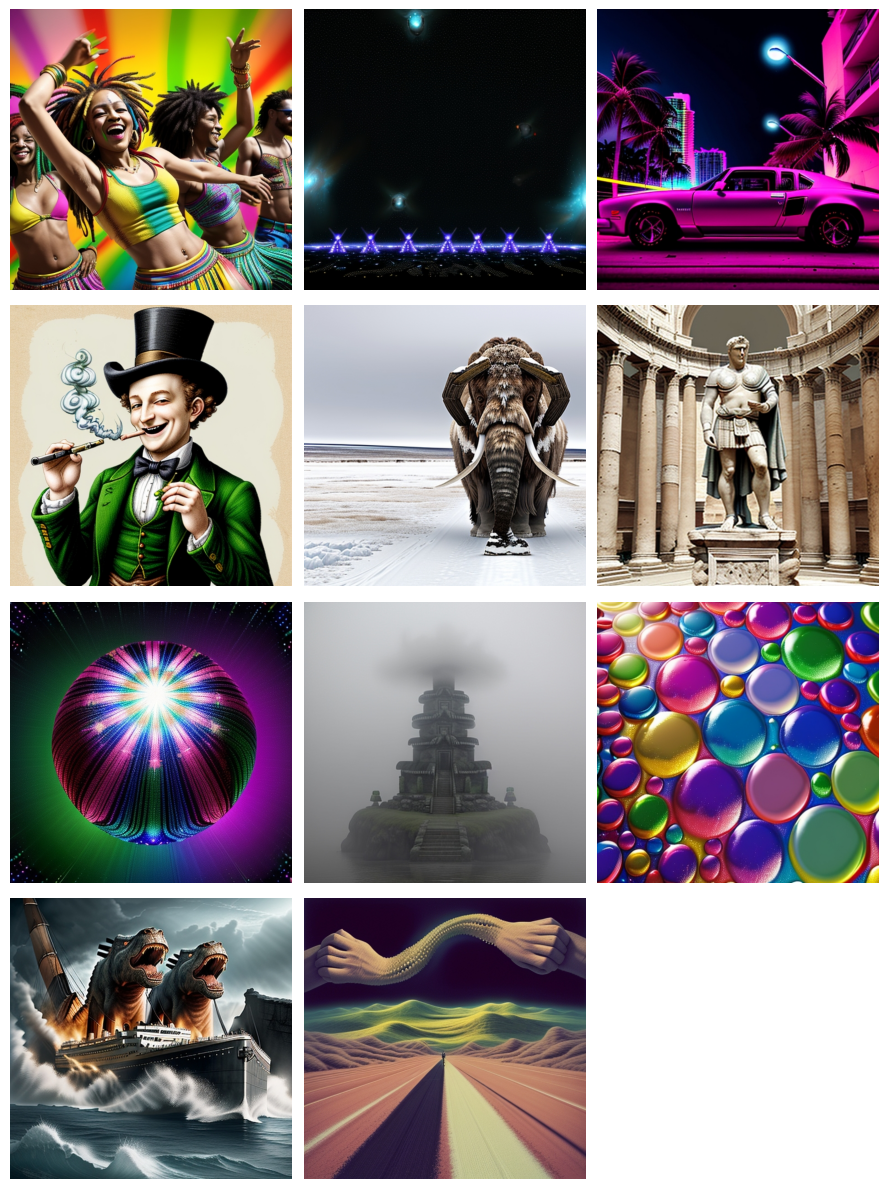

In [226]:
#@title Grid from multiple prompts
leonardo = LeonardoAI(api_key=LEONARDO_AI_API_KEY, num_inference_steps=60,negative_prompt=None, guidance_scale=15)
generation_id = leonardo.generate_image(prompts=prompts, width=512, height=512, num_images=3, model_id="e316348f-7773-490e-adcd-46757c738eb7")
generations = leonardo.retrieve_images(generation_id)
leonardo.display_images(generations)

{"sdGenerationJob":{"generationId":"4b4914fd-cf0b-43f3-bc0f-5e5b756c60cb"}}


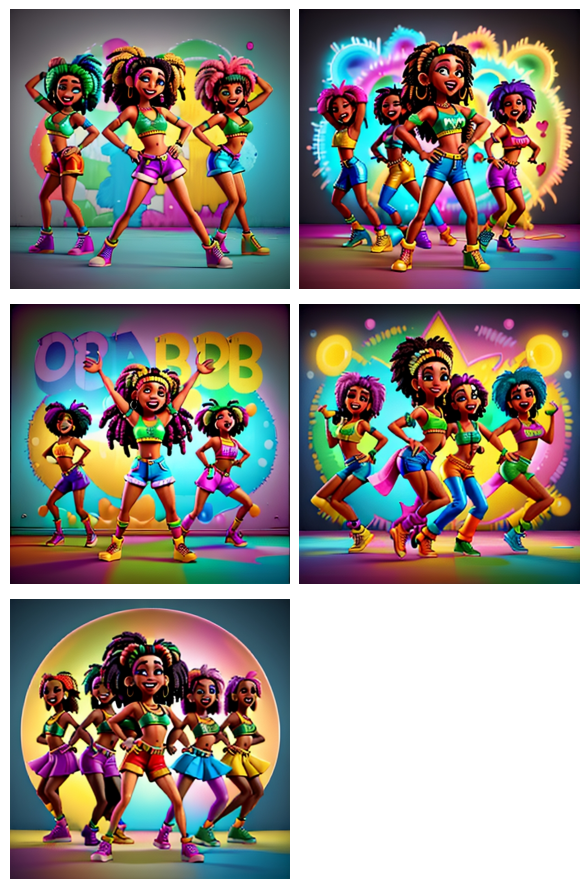

In [232]:
#@title Grid with versions from single prompt
leonardo = LeonardoAI(api_key=LEONARDO_AI_API_KEY, num_inference_steps=60,negative_prompt=None, guidance_scale=15)
generation_id = leonardo.generate_image(prompts=f"{prompts[:1]} with the words '80s throwback' written in graffiti style", width=512, height=512, num_images=5, model_id="d69c8273-6b17-4a30-a13e-d6637ae1c644")
generations = leonardo.retrieve_images(generation_id)
leonardo.display_images(generations)